# Using Sumatra with Pandas in IPython

This notebook demonstrates how to use
[Sumatra](http://neuralensemble.org/sumatra/) to capture simulation
input data and meta data and then
export these records into a Pandas data frame.  Sumatra has a stand
alone web interface built with Django which allows users to view the
data. Data can also be imported into Python, but requires a lot of
code to manipulate and display in useful custom formats. Pandas seems
like the ideal solution for manipulating Sumatra's data. In particular
the ability to easily and quickly combine input data, meta data, and
output data into custom data frames is really powerful for
data analysis, reproduciblity and sharing.

The first step in using Sumatra is to setup a simulation. Here the
simulation just runs a diffusion problem using FiPy and outputs the
time taken for a time step. The goal of the work is to test FiPy's parallel
speed up based on different input parameters.


# Setup the Simulations

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

Sumatra requires a file with the parameters specified.

In [2]:
#creates a params.json dictionary {N,steps}
import json
import hackathon_params as hp

hp.hackParams(10,2)

The script file for running the simulation is `hack1.py`. It reads the JSON file, runs the simulation and the stores the run times in `data.txt`.

In [5]:
%%writefile hack1.py

import fipy as fp
import numpy as np
import json
import os
import hackathon_params as hp
import sys
import resource
#from guppy import hpy

memory1 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss #get initial memory peak
# mem = hpy()

jsonfile = sys.argv[1]

if jsonfile:
    with open(jsonfile, 'rb') as ff:
        params = json.load(ff)
else:
    params = dict()

#print type(params)
print 'my params:', params



N = params.get('N',20)
total_steps = params.get('steps',2)
sumatra_label = params.get('sumatra_label', '')

mesh = fp.PeriodicGrid2D(nx=N, ny=N, dx=0.5, dy=0.5)    # changed 400 to 40 for nx and ny to test a faster run

c_alpha = 0.05
c_beta = 0.95
A = 2.0
kappa = 2.0
c_m = (c_alpha + c_beta) / 2.
B = A / (c_alpha - c_m)**2
D = D_alpha = D_beta = 2. / (c_beta - c_alpha)
c_0 = 0.45
q = np.sqrt((2., 3.))
epsilon = 0.01

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

r = np.array((mesh.x, mesh.y))
c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))

f_0_var = -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2

eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(D * f_0_var) - fp.DiffusionTerm((D, kappa))

elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
#total_steps = 2       #from 1000 to 100

c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))

c_var.updateOld()

from fipy.solvers.pysparse import LinearLUSolver as Solver

solver = Solver()

# viewer = fp.Viewer(c_var)
while steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)

        print ' '
#         print 'steps',steps
#         print 'res',res
#         print 'sweeps',sweeps
#         print 'dt',dt


    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
#         if steps % 1 == 0:
#              viewer.plot('image{0}.png'.format(steps))
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old
        
        
    #create a filepath and txt file to save the output c_var values
    filepath = os.path.join('Data', sumatra_label)
    filename = 'c_var_outputs.txt'
    np.savetxt(os.path.join(filepath, filename), np.array(c_var))
    
#Keep track os how much memory was used and dump into a txt file
# memory = mem.heap()
memory2 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss #final memory peak
memory_diff = (memory2 - memory1,)
# print memory_diff
# print type(memory_diff)
filename2 = 'memory_usage.txt'
np.savetxt(os.path.join(filepath, filename2), memory_diff )


Overwriting hack1.py


Without using Sumatra and in serial this is run with

In [9]:
#to install gmsh run "conda install --channel guyer numpy==1.9 pysparse pip gmsh"
#to install PyTrilinos run "conda install --channel guyer numpy==1.9 pysparse openmpi trilinos mpi4py"
#trilinos is mainly used for linear solvers, it also includes PDE solvers but they are low level, FiPy is a better PDE solvers

#but actually you should use pysparse instead of trilinos
!python hack1.py params.json

my params: {u'steps': 2, u'N': 10}
 
 
 
 


and the output data file is 

In [8]:
!ls Data/

034678ec13cd  2e4570d850a4  76901549ccd0  b2331f3fcb03	     e1e234bcfcc7
052b46043c22  335ad0f003ba  779d02f0c3e8  b636582393bc	     e38c1cd6dbf7
06723a4349da  340cd4286bde  86f327cc1588  bd99ee5ef47e	     e4ee2e89c581
090ef4388958  36a112015922  8df059ad7d76  c124f1d180d9	     e6a47fb8223f
0ca542afe0c5  4a1f4b8e1192  94f48135d491  c9ec3e4caf03	     e8ad6a451d27
10269ed88acf  4f41d0ab8d48  951d3e5bceb4  ca8e1eb702ea	     ea2f6a268f0c
15a42701deca  5040813d5a3f  98812abd136d  cea1345335b5	     ef3a66163116
15d77462d0b8  534fc0751b1f  9aa6beffe99d  c_var_outputs.txt  f26f36cf9d43
1ad2421806fb  55513714ade7  9abf976098cc  d071690c19f1	     f6d3a98e632c
1d85137ef137  59e9b1411633  a2b97de6ecb3  d3e31cd6d95f	     f7781a6136ac
210be7a38c9a  59f7e2947345  a363c8943090  d557e4f50599	     fbf0cee1da17
22991c08b06b  6491b56f0a3e  a609a4f54861  d8378b287345	     memory_usage.txt
22ed7e7836f5  64b22ecbf5dd  a90f977b7c69  data.txt
2510d817a8ae  698f8ca9bb4a  a9b63890c458  dbfa95d2ff98
25befcc43d27 

# Create a Git Repository

In this demo, I'm assuming that the working directory is a Git repository set up with

    $ git init
$ git add hack1.py
    $ git ci -m "Add timing script."
    
Sumatra requires that the script is sitting in the a working copy of a repository.

In [30]:
!git log -1

commit cf2e93ee897f9a8ac5091021bb5e6b431ad0f831
Author: Andrey Moskalenko <andrey.moskalenko@nist.gov>
Date:   Mon Jun 6 11:15:28 2016 -0400

    added hack1 file to run with the python notebook


# Configure Sumatra

Once the repository is setup, the Sumatra repository can be configured. Here we are using the `distributed` launch mode as we want Sumatra to launch and
record parallel jobs.

In [5]:
%%bash

rm -rf .smt
smt init hack1-demo
smt configure --executable=python --main=hack1.py
smt configure --launch_mode=serial
smt configure -g uuid
smt configure -c store-diff
smt configure --addlabel=parameters

Sumatra project successfully set up
Multiple versions found, using /users/aem1/miniconda2/bin/python. If you wish to use a different version, please specify it explicitly
Multiple versions found, using /users/aem1/miniconda2/bin/python. If you wish to use a different version, please specify it explicitly


Sumatra requires that  a `Data/` directory exists in the working copy.

In [54]:
!mkdir Data

mkdir: cannot create directory ‘Data’: File exists


If we were not using Sumatra, we would launch the job with 

    $ mpirun -n 2 python hack1.py params.json
    
The equivalent command using Sumatra is

    $ smt run -n 2 params.json
 

# Run Simulations

In the following cell we just run a batch of simulations with varying parameters.

In [56]:
import itertools
from guppy import hpy

#create a variable to keep track of memory

N=(10, 15)
steps=(2,)
tag='hack1'

for N, steps in itertools.product(N, steps):
    hp.hackParams(N,steps)
    !smt run params.json --tag=$tag
    

my params: {u'N': 10, u'steps': 2, u'sumatra_label': u'bd99ee5ef47e'}
 
 
 
 
(3364,)
<type 'tuple'>
Record label for this run: 'bd99ee5ef47e'
Data keys are [c_var_outputs.txt(5773e6905d793fef15e54c55441c9e6112eb284c [2016-06-08 12:02:28]), memory_usage.txt(eab392104f75d214ac6316a5e6bf020656fba411 [2016-06-08 12:02:28])]
my params: {u'N': 15, u'steps': 2, u'sumatra_label': u'4f41d0ab8d48'}
 
 
 
 
(3824,)
<type 'tuple'>
Record label for this run: '4f41d0ab8d48'
Data keys are [c_var_outputs.txt(e8117ef32855265eae8a0d24efe5e47f1d9715aa [2016-06-08 12:03:29]), memory_usage.txt(c2dc65b1ff00a80bd8fa6fae1e33ab23335a62e6 [2016-06-08 12:03:29])]


# Import into Pandas Dataframe

The important part of this story is how to import the data into the Pandas data frame. This is actually trivial as Sumatra's default export format is a JSON file with all the records.

In [60]:
#del(df)
print df

                                            datastore  \
0   {u'type': u'FileSystemDataStore', u'parameters...   
1   {u'type': u'FileSystemDataStore', u'parameters...   
2   {u'type': u'FileSystemDataStore', u'parameters...   
3   {u'type': u'FileSystemDataStore', u'parameters...   
4   {u'type': u'FileSystemDataStore', u'parameters...   
5   {u'type': u'FileSystemDataStore', u'parameters...   
6   {u'type': u'FileSystemDataStore', u'parameters...   
7   {u'type': u'FileSystemDataStore', u'parameters...   
8   {u'type': u'FileSystemDataStore', u'parameters...   
9   {u'type': u'FileSystemDataStore', u'parameters...   
10  {u'type': u'FileSystemDataStore', u'parameters...   
11  {u'type': u'FileSystemDataStore', u'parameters...   
12  {u'type': u'FileSystemDataStore', u'parameters...   
13  {u'type': u'FileSystemDataStore', u'parameters...   
14  {u'type': u'FileSystemDataStore', u'parameters...   
15  {u'type': u'FileSystemDataStore', u'parameters...   
16  {u'type': u'FileSystemDataS

In [59]:
import json
import pandas

!smt export
with open('.smt/records_export.json') as ff:
    data = json.load(ff)
    
with open('record1.json', 'w') as record1:
    for entry in range(len(data)):
        record1.write(json.dumps(data[entry], sort_keys=True, indent=4, separators=(',', ': ')))

df = pandas.DataFrame(data)

The Sumatra data is now in a Pandas data frame, albeit a touch raw.

In [93]:
#How to add a porper column to a dataframe. The array must be the same length as the dataframe
# frame = df.copy()
# print type(frame)
# print type(df)
# arr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
# frame

# frame['stuff']=arr
# frame['stuff']

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
Name: stuff, dtype: int64

In [68]:
print df['output_data'][0][1]['path']

memory_usage.txt


In [62]:
print df[['label', 'duration']]

           label  duration
0   4f41d0ab8d48  1.692265
1   bd99ee5ef47e  1.340750
2   a363c8943090  6.824560
3   8df059ad7d76  4.038260
4   15a42701deca  1.690229
5   22991c08b06b  6.143306
6   534fc0751b1f  4.022114
7   ef3a66163116  1.449261
8   779d02f0c3e8  4.782407
9   e8ad6a451d27  2.897822
10  98812abd136d  1.432834
11  e6a47fb8223f  5.025449
12  c9ec3e4caf03  2.970374
13  36a112015922  1.384827
14  d8378b287345  4.363858
15  052b46043c22  2.397974
16  f26f36cf9d43  3.808108


# Reformat the Raw Imported Dataframe

While all the meta data is important, often we want the input and
output data combined into a data frame in a digestible
form. Typically, we want a graph of reduced input versus reduced
output.

The first step is to introduce columns in the data frame for each of the input parameters (input data). The input data is buried in the `launch_mode` and `parameters` columns of the raw data frame.

In [12]:
for index in range(len(df['launch_mode'])):
   print df['launch_mode'][index]['type']
#    print df['launch_mode'][index]['parameters']

SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode
SerialLaunchMode


In [7]:
import json
df = df.copy()
print df.parameters
df['nproc'] = 1 # We are running in serial
for p in 'N', 'steps':
    df[p] = df.parameters.map(lambda x: json.loads(x['content'])[p])

# print df.parameters[0]

0     {u'content': u'{
    "N": 40, 
    "steps": 20...
1     {u'content': u'{
    "N": 40, 
    "steps": 10...
2     {u'content': u'{
    "N": 40, 
    "steps": 2,...
3     {u'content': u'{
    "N": 30, 
    "steps": 20...
4     {u'content': u'{
    "N": 30, 
    "steps": 10...
5     {u'content': u'{
    "N": 30, 
    "steps": 2,...
6     {u'content': u'{
    "N": 20, 
    "steps": 20...
7     {u'content': u'{
    "N": 20, 
    "steps": 10...
8     {u'content': u'{
    "N": 20, 
    "steps": 2,...
9     {u'content': u'{
    "N": 15, 
    "steps": 20...
10    {u'content': u'{
    "N": 15, 
    "steps": 10...
11    {u'content': u'{
    "N": 15, 
    "steps": 2,...
12    {u'content': u'{
    "N": 10, 
    "steps": 20...
13    {u'content': u'{
    "N": 10, 
    "steps": 10...
14    {u'content': u'{
    "N": 10, 
    "steps": 2,...
Name: parameters, dtype: object


We now have the input data exposed as columns in the data frame.

In [8]:
columns = ['label', 'nproc', 'N', 'steps', 'tags', 'duration']
print df[columns]

           label  nproc   N  steps     tags  duration
0   a363c8943090      1  40     20  [hack1]  6.824560
1   8df059ad7d76      1  40     10  [hack1]  4.038260
2   15a42701deca      1  40      2  [hack1]  1.690229
3   22991c08b06b      1  30     20  [hack1]  6.143306
4   534fc0751b1f      1  30     10  [hack1]  4.022114
5   ef3a66163116      1  30      2  [hack1]  1.449261
6   779d02f0c3e8      1  20     20  [hack1]  4.782407
7   e8ad6a451d27      1  20     10  [hack1]  2.897822
8   98812abd136d      1  20      2  [hack1]  1.432834
9   e6a47fb8223f      1  15     20  [hack1]  5.025449
10  c9ec3e4caf03      1  15     10  [hack1]  2.970374
11  36a112015922      1  15      2  [hack1]  1.384827
12  d8378b287345      1  10     20  [hack1]  4.363858
13  052b46043c22      1  10     10  [hack1]  2.397974
14  f26f36cf9d43      1  10      2  [hack1]  3.808108


The following pulls out the run times stored in the output files from each simulation into a `run_time` column.

In [134]:
df['output_data'][2]
df['datastore'][0]['parameters']['root']
len(df.index) #gives the number of rows in the dataframe

17

Now we need to extract all the memory usage numbers so we can add them to the dataframe

In [133]:
num = 0
memoryArray = np.array([])
for num in range(2):
    memName = df['output_data'][num][1]['path']
    memlocation = df['datastore'][num]['parameters']['root']
    pool = os.path.join(memlocation, memName)
    memdata = np.loadtxt(pool)
    memoryArray = np.append(memoryArray, memdata)
    print memoryArray
#print df['output_data'][0][1]['path']

[ 3824.]
[ 3824.  3364.]


In [122]:
import os
import numpy as np

datafiles = df['output_data'].map(lambda x: x[0]['path']) 
datapaths = df['datastore'].map(lambda x: x['parameters']['root'])
data = [np.loadtxt(os.path.join(x, y)) for x, y in zip(datapaths, datafiles)]
print data
#df['run_time'] = [min(d) for d in data]
# print df['output_data'][0]
type(datafiles)

[array([ 0.44855982,  0.44807944,  0.44690141,  0.44624037,  0.44695085,
        0.44899289,  0.45150789,  0.45331846,  0.45355423,  0.45209884,
        0.44965009,  0.44736522,  0.44625518,  0.44661388,  0.44779211,
        0.44810586,  0.44717231,  0.44667476,  0.44734631,  0.44916021,
        0.45137256,  0.4529539 ,  0.45314228,  0.45183907,  0.44966036,
        0.44762139,  0.44660272,  0.44685591,  0.44782239,  0.44846676,
        0.44883189,  0.44800638,  0.44837558,  0.44984371,  0.45162036,
        0.45274814,  0.45261418,  0.45124694,  0.44928851,  0.44766653,
        0.4471208 ,  0.44780413,  0.44915493,  0.45015803,  0.44999307,
        0.45030134,  0.45009229,  0.45097479,  0.45218992,  0.45278451,
        0.45222592,  0.45065783,  0.44878395,  0.44748834,  0.44738498,
        0.44850562,  0.45026832,  0.45175062,  0.45217411,  0.45142096,
        0.45155668,  0.45206916,  0.45279563,  0.45289529,  0.45194112,
        0.45017803,  0.44835777,  0.44732049,  0.44755575,  0.4

pandas.core.series.Series

Create masks based on simulations records that have been tagged with either `demo2` or `demo3`. We want to plot these results as different curves on the same graph.

In [31]:
tag_mask = df.tags.map(lambda x: 'hack1' in x)
df_tmp = df[tag_mask]
# print df_tmp
#these will organize the data by the grid size
m10 = df_tmp.N.map(lambda x: x == 10)
m15 = df_tmp.N.map(lambda x: x == 15)
m20 = df_tmp.N.map(lambda x: x == 20)
m30 = df_tmp.N.map(lambda x: x == 30)
m40 = df_tmp.N.map(lambda x: x == 40)
df_N10 = df_tmp[m10]
df_N15 = df_tmp[m15]
df_N20 = df_tmp[m20]
df_N30 = df_tmp[m30]
df_N40 = df_tmp[m40]
# print df_N10[columns]
# print df_N15[columns]
# print df_N20[columns]
# print df_N30[columns]
# print df_N40[columns]


#these will organize data by the number of steps
s2 = df_tmp.steps.map(lambda x: x == 2)
s10 = df_tmp.steps.map(lambda x: x == 10)
s20 = df_tmp.steps.map(lambda x: x == 20)

df_s2 = df_tmp[s2]
df_s10 = df_tmp[s10]
df_s20 = df_tmp[s20]

print df_s2[columns]
print df_s10[columns]
print df_s20[columns]
# print df_tmp

           label  nproc   N  steps     tags  duration
2   15a42701deca      1  40      2  [hack1]  1.690229
5   ef3a66163116      1  30      2  [hack1]  1.449261
8   98812abd136d      1  20      2  [hack1]  1.432834
11  36a112015922      1  15      2  [hack1]  1.384827
14  f26f36cf9d43      1  10      2  [hack1]  3.808108
           label  nproc   N  steps     tags  duration
1   8df059ad7d76      1  40     10  [hack1]  4.038260
4   534fc0751b1f      1  30     10  [hack1]  4.022114
7   e8ad6a451d27      1  20     10  [hack1]  2.897822
10  c9ec3e4caf03      1  15     10  [hack1]  2.970374
13  052b46043c22      1  10     10  [hack1]  2.397974
           label  nproc   N  steps     tags  duration
0   a363c8943090      1  40     20  [hack1]  6.824560
3   22991c08b06b      1  30     20  [hack1]  6.143306
6   779d02f0c3e8      1  20     20  [hack1]  4.782407
9   e6a47fb8223f      1  15     20  [hack1]  5.025449
12  d8378b287345      1  10     20  [hack1]  4.363858


We can plot the results we're interested in. Larger system size gives better parallel speed up.

In [48]:
print type(df_s2['duration'])
np.array(df_s2['N'])
?

<class 'pandas.core.series.Series'>


array([40, 30, 20, 15, 10])

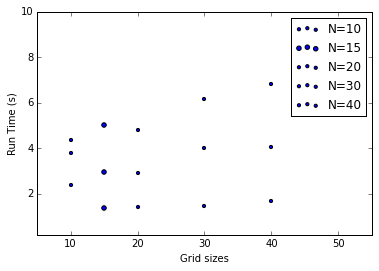

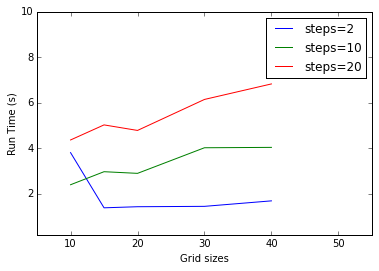

In [67]:
#The first graph is plotting all the points
ax = df_N10.plot('N', 'duration', kind='scatter', s=10, label='N={0}'.format(df_N10.N.iat[0]))
df_N15.plot('N', 'duration', kind='scatter', ylim=0, ax=ax, label='N={0}'.format(df_N15.N.iat[0]))
df_N20.plot('N', 'duration', kind='scatter', marker='o', s=10, ylim=0, ax=ax, label='N={0}'.format(df_N20.N.iat[0]))
df_N30.plot('N', 'duration', kind='scatter', s=10, ylim=0, ax=ax, label='N={0}'.format(df_N30.N.iat[0]))
df_N40.plot('N', 'duration', kind='scatter', s=10, ylim=0, ax=ax, label='N={0}'.format(df_N40.N.iat[0]))

ax.set_xlim([5,55])
ax.set_ylim([.2,10])
plt.ylabel('Run Time (s)')
plt.xlabel('Grid sizes')
plt.legend()

#The second graph create lines for each steps size to see the evolution of 
# run duration with increasing grid sizes for the various step sizes
stepGraph = df_s2.plot('N', 'duration', kind='line', ylim=0, label='steps={0}'.format(df_s2.steps.iat[0]))
df_s10.plot('N', 'duration', kind='line', ylim=0, ax=stepGraph, label='steps={0}'.format(df_s10.steps.iat[0]))
df_s20.plot('N', 'duration', kind='line', ylim=0, ax=stepGraph, label='steps={0}'.format(df_s20.steps.iat[0]))

stepGraph.set_xlim([5,55])
stepGraph.set_ylim([.2,10])
plt.ylabel('Run Time (s)')
plt.xlabel('Grid sizes')
plt.legend()



Using Pandas it is easy to store a custom data frame.

In [115]:
df.to_hdf('store.h5', 'df')

ImportError: HDFStore requires PyTables, "No module named tables" problem importing

In [116]:
b
print store.df.dependencies

NameError: name 'b' is not defined

In [117]:
import pandas as pd

df = pd.DataFrame({'a' : [1, 2, 3], 'b' : ['a', 'b', 'c']})
df['c'] = [5, 6, 7]
print df


   a  b  c
0  1  a  5
1  2  b  6
2  3  c  7


# Conclusion

Sumatra stores data in an SQL style database and this isn't ideal for pulling data into Python for data manipulation. Pandas is good for data manipulation and pulling the records out of Sumatra and into Pandas is very easy.